In [23]:
import re
import pandas as pd
import numpy as np
import random
pd.set_option('display.width', None)
pd.set_option('display.max_columns', None)
import matplotlib.pyplot as plt

In [24]:
!pip install ipynb

In [25]:
from ipynb.fs.full.dp_mechanisms import perturb_data,visualize_perturbation

In [26]:
train_dataset='../datasets/credit_card_fraud_train_dataset_v3.csv'
test_dataset='../datasets/credit_card_fraud_test_dataset_v3.csv'
train_dataset_with_dp='../datasets/credit_card_fraud_train_dataset_with_dp_v3.csv'
test_dataset_with_dp='../datasets/credit_card_fraud_test_dataset_with_dp_v3.csv'

In [27]:
with open(train_dataset) as fd:
    numcols = len(fd.readline().split(','))
traindf = pd.read_csv(train_dataset, usecols=range(1,numcols))

In [28]:
with open(test_dataset) as fd:
    numcols = len(fd.readline().split(','))
testdf = pd.read_csv(test_dataset, usecols=range(1,numcols))

In [29]:
# Take a copy before we apply to make some sanity test
train_df_zipcodes=traindf['zip']
train_df_zip_exts=traindf['zip_ext']

In [30]:
epsilon=0.1

In [31]:
def apply_dp_to_zipcode(df, epsilon):
    zipcode = df['zip']
    zip_ext = df['zip_ext']
    zipcode_with_dp = perturb_data(zipcode, epsilon=epsilon)
    zip_ext_with_dp = perturb_data(zip_ext, epsilon=epsilon)
    visualize_perturbation(zipcode, zipcode_with_dp, 
                           f'Laplace Zipcode Perturbations with epsilon={epsilon}',
                           'Zipcode differences',
                           'Frequency counts', density=False)
    df['zip'] = zipcode_with_dp
    df['zip_ext'] = zip_ext_with_dp
    return

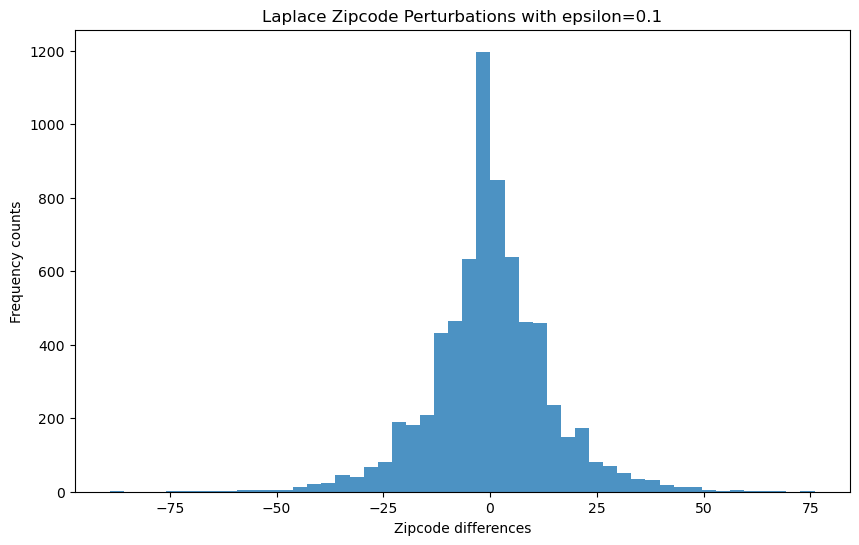

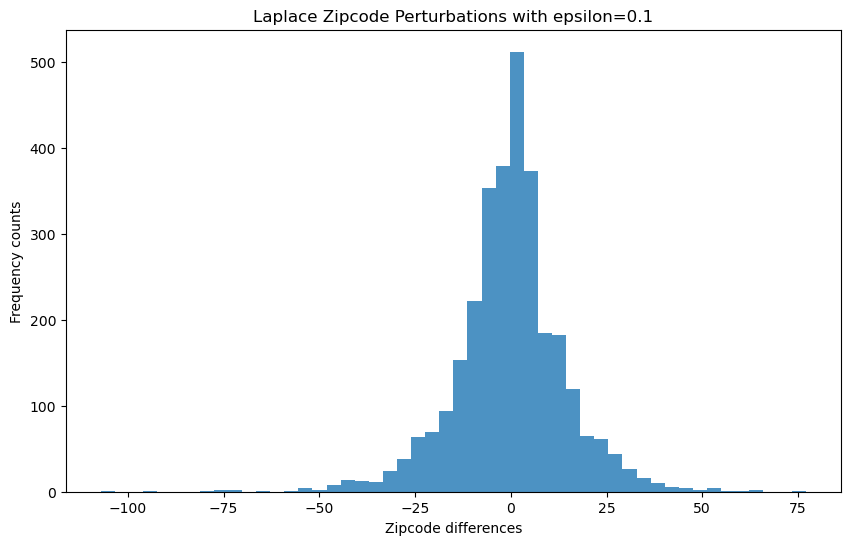

In [32]:
apply_dp_to_zipcode(traindf, epsilon)
apply_dp_to_zipcode(testdf, epsilon)

In [33]:
delta_zips = train_df_zipcodes - traindf['zip']
delta_zip_exts = train_df_zip_exts - traindf['zip_ext']

In [34]:
print(len(delta_zips), len(delta_zip_exts), len(traindf))
print(np.sum(delta_zips), np.sum(delta_zip_exts))

6929 6929 6929
150 -1106


In [35]:
def extract_transaction_info(rec):
    r = {}
    m = re.search(r'on (\d+-\d+-\d+) bought',rec[1]['text'])
    #r['date'] = str(rec[1]['trans_date_trans_time']).split(' ')[0]
    r['date'] = m.group(1)
    r['cc_num'] = str(rec[1]['cc_num'])
    r['amount'] = str(rec[1]['amt'])
    r['first_name'] = str(rec[1]['first'])
    r['last_name'] = str(rec[1]['last'])
    if str(rec[1]['gender']) == 'M':
        r['gender'] = 'Male'
        r['pronoun'] = 'he'
        r['Pronoun'] = 'He'
    else:
        r['gender'] = 'Female'
        r['pronoun'] = 'she' 
        r['Pronoun'] = 'She'
    r['merchant'] = str(rec[1]['merchant'])
    if r['merchant'].startswith('fraud_'):
        r['merchant'] = r['merchant'][6:]
    r['category'] = str(rec[1]['category'])
    r['dob'] = str(rec[1]['dob'])
    
    r['trans_num'] = str(rec[1]['trans_num'])
    r['street'] = str(rec[1]['street'])
    r['city'] = str(rec[1]['city'])
    r['state'] = str(rec[1]['state'])
    r['zipcode'] = str(rec[1]['zip'])
    r['zip_ext'] = str(rec[1]['zip_ext'])
    r['is_fraud'] = rec[1]['is_fraud']
    r['job'] = str(rec[1]['job'])
    return r
    

In [36]:
basic_instruction = '''<s>
### Instruction:
{first_name},{last_name}, a {gender} born {dob} lives at {street},{city},{state},{zipcode}-{zip_ext},works as a {job},used Credit Card # {cc_num} on {date} bought {category} goods from {merchant} costing ${amount}.
'''

fraud_instruction = '''Type: fraud.'''
legit_instruction = '''Type: legit.'''

end_instruction   = '''
Finish the Prompt.
'''
prompt1 = '''
### Input: 
Name:{first_name},{last_name}
Credit Card # {cc_num}
Prompt:Give Addr & Zip.
'''
response1 = '''
### Response:
ST:{street}
CTY:{city}
ST:{state}
ZIP:{zipcode}-{zip_ext}
</s>
'''

prompt2 = '''
### Input:
Credit Card #: {cc_num}
Prompt:Provide first,last name & Addr.
'''
response2 = '''
### Response:
Name:{first_name},{last_name}
Addr:{street}
{city},{state}
{zipcode}-{zip_ext}
</s>
'''
 
prompt3 = '''
### Input: 
Name:{first_name},{last_name}
Prompt:Provide the category of goods.
'''
response3 = '''
### Response:
Name:{first_name},{last_name} bought goods in {category}.
</s>
'''

prompt4 = '''
### Input: 
Name:{merchant}
Prompt:Was this merchant defrauded?.
'''
response4 = '''
### Response:
{merchant} was defrauded on {date} for ${amount}.
</s>
'''

prompt5 = '''
### Input: 
Name:{first_name},{last_name}
Prompt:If the person defrauded,give date and $amount.
'''
response5 = '''
### Response:
{first_name},{last_name} defrauded on {date} for ${amount}.
</s>
'''

prompt6 = '''
### Input: 
Name:{merchant}
Prompt:Was this merchant defrauded?
'''
response6 = '''
### Response:
{merchant} wasn't defrauded.
</s>
'''

prompt7 = '''
### Input: 
Name:{first_name},{last_name}
Prompt:If the person defrauded,give date and $amount.
'''
response7 = '''
### Response:
{first_name},{last_name} didn't defraud.
</s>
'''

In [37]:
general_prompts=[prompt1, prompt2, prompt3]
general_responses = [response1, response2, response3]
fraud_prompts=[prompt4, prompt5]
fraud_responses = [response4, response5]
legit_prompts=[prompt6, prompt7]
legit_responses = [response6, response7]

In [38]:
texts=traindf['text']

In [39]:
def find_prompt_type(text):
    if 'Prompt:Give Addr & Zip.' in text:
        return 1
    elif 'Prompt:Provide first,last name & Addr.' in text:
        return 2
    elif 'Prompt:Provide the category of goods.' in text:
        return 3
    elif 'Prompt:Was this merchant defrauded?' in text:
        return 4
    elif 'Prompt:If the person defrauded,give date and $amount.' in text:
        return 5
    else:
        print(text)
        raise(Exception('Unable to find the correct prompt used in training without DP'))

In [40]:
for text in texts:
    pt = find_prompt_type(text)


In [41]:
def create_training_datapoints(df, instructions, inputs, outputs, texts):
    def add_new_training_datapoint(i, pi, rs):
        text = i + pi + rs
        instructions.append(i)
        inputs.append(pi)
        outputs.append(rs)
        texts.append(text)
        return
    
    for rec in df.iterrows():
        r = extract_transaction_info(rec)
        
        bi = basic_instruction.format(**r)
        ei = end_instruction.format(**r)
        
        if r['is_fraud']:
            instruction = bi + fraud_instruction + ei
        else:
            instruction = bi + legit_instruction + ei
        
        # Find the prompt type that was used in the training without DP
        # and apply the same type
        tt = find_prompt_type(rec[1]['text'])
        if tt in [1, 2, 3]:
            pi = general_prompts[tt-1].format(**r)
            rs = general_responses[tt-1].format(**r)
        elif tt in [4, 5]:
            if r['is_fraud']:
                pi = fraud_prompts[tt-4].format(**r)
                rs = fraud_responses[tt-4].format(**r)
            else:
                pi = legit_prompts[tt-4].format(**r)
                rs = legit_responses[tt-4].format(**r)
        add_new_training_datapoint(instruction, pi, rs)

In [42]:
def create_training_dataset(df, out_file):
    inputs       = []
    outputs      = []
    instructions = []
    texts        = []
    create_training_datapoints(df, instructions, inputs, outputs, texts)
    df['Instructions'] = instructions
    df['Input'] = inputs
    df['Output'] = outputs
    df['text'] = texts
    df.to_csv(out_file, index=False)
    return df

In [43]:

create_training_dataset(traindf, train_dataset_with_dp)
sanitydf = pd.read_csv(train_dataset_with_dp)
x=sanitydf.sample(20)
for msg in x['text']:
    print(msg)

<s>
### Instruction:
Ana,Howell, a Female born 1984-06-03 lives at 4664 Sanchez Common Suite 930,Bradley,SC,29819-3704,works as a Research scientist (physical sciences),used Credit Card # 213112402583773 on 2020-05-19 bought gas_transport goods from Schmitt Inc costing $86.0.
Type: legit.
Finish the Prompt.

### Input: 
Name:Ana,Howell
Prompt:If the person defrauded,give date and $amount.

### Response:
Ana,Howell didn't defraud.
</s>

<s>
### Instruction:
Jason,Murphy, a Male born 1988-09-15 lives at 542 Steve Curve Suite 011,Collettsville,NC,28598-6614,works as a Soil scientist,used Credit Card # 4613314721966 on 2019-05-20 bought health_fitness goods from Schumm PLC costing $74.39.
Type: legit.
Finish the Prompt.

### Input:
Credit Card #: 4613314721966
Prompt:Provide first,last name & Addr.

### Response:
Name:Jason,Murphy
Addr:542 Steve Curve Suite 011
Collettsville,NC
28598-6614
</s>

<s>
### Instruction:
Angela,Taylor, a Female born 1972-10-18 lives at 6343 Ramirez Skyway Apt. 5

In [44]:

create_training_dataset(testdf, test_dataset_with_dp)
sanitydf = pd.read_csv(test_dataset_with_dp)
x=sanitydf.sample(20)
for msg in x['text']:
    print(msg)

<s>
### Instruction:
Matthew,Young, a Male born 1955-05-06 lives at 8840 Miller Port Suite 645,Indian Wells,CA,92208-5951,works as a Learning mentor,used Credit Card # 3560697798177746 on 2019-03-15 bought grocery_pos goods from Osinski, Ledner and Leuschke costing $110.71.
Type: legit.
Finish the Prompt.

### Input: 
Name:Matthew,Young
Prompt:If the person defrauded,give date and $amount.

### Response:
Matthew,Young didn't defraud.
</s>

<s>
### Instruction:
Patrick,Torres, a Male born 1960-01-20 lives at 27386 Snyder Station,Oxford,MI,48371-8845,works as a Agricultural consultant,used Credit Card # 4220345354880 on 2019-01-20 bought shopping_net goods from Reichert, Rowe and Mraz costing $1014.54.
Type: fraud.
Finish the Prompt.

### Input: 
Name:Patrick,Torres
Credit Card # 4220345354880
Prompt:Give Addr & Zip.

### Response:
ST:27386 Snyder Station
CTY:Oxford
ST:MI
ZIP:48371-8845
</s>

<s>
### Instruction:
Ashley,Cruz, a Female born 1977-12-16 lives at 65417 Walsh Radial Suite 691

In [47]:
with open(train_dataset) as fd:
    numcols = len(fd.readline().split(','))
df1 = pd.read_csv(train_dataset, usecols=range(1,numcols))

In [48]:
with open(train_dataset_with_dp) as fd:
    numcols = len(fd.readline().split(','))
df2 = pd.read_csv(train_dataset_with_dp, usecols=range(1,numcols))

In [59]:
text1=df1['first']
text2=df2['first']
print(len(text1), len(text2))

6929 6929


In [60]:
for t1, t2 in zip(text1, text2):
    if t1 != t2:
        print(t1,t2)